**R-CNN implimetation**                                                         
In this notebook we will learn to impliment R-CNN network on airplane detection task, using some of the popular deep-learning frameworks.  

**Mounting Gdrive** --
In the below tab we are going to mount our google drive to reach particular directories and load data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Installing tensorflow2.0.0**

In [ ]:
!pip install tensorflow==2.0.0-beta0

Check Tensorflow Version

In [ ]:
import tensorflow as tf
tf.__version__

Changing Working Directory to Directory where data is stored

In [ ]:
cd /content/drive/MyDrive/End-to-end-Cv/R-CNN

We will start by loading in the packages

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Run this cell to set the path and annot to the address of your image folder and Airplanes_Annotations folder.

In [ ]:
path = "/content/drive/MyDrive/End-to-end-Cv/R-CNN/Images"
annot = "/content/drive/MyDrive/End-to-end-Cv/R-CNN/Airplanes_Annotations"

Our airplane dataset contains two parts   
1) Image part-> Contain pictures of airplanes   
2) Airplanes_Annotations-> Contain information about bounding boxes for the pictures available.     
The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `Index` below and re-run to see different examples.

In [ ]:
        Index=148
        filename = "airplane_"+str(Index)+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,filename.replace(".jpg",".csv")))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

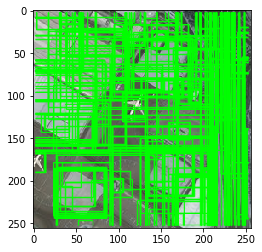

In [ ]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [ ]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

**Preparing training data**
Training data here is prepared according to following scheme:-   
a) Those boxes which have an IoU greater than 0.7 (original paper it's 0.5) are considered as a positive example.   
b) And boxes with relative low IoU 0.3 are taken to be negative examples.  
Number of regions taken here is 30 positive and 30 negative (original paper have 32 and 96 respectively) of size 224x224.
Note- Original paper also talk about warping but as we have resized them already so there is no need of it.

In [ ]:
# At the end of below code we will have our train data in these lists
train_images=[]
train_labels=[]

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)   # setting given image as base image
            ss.switchToSelectiveSearchFast()     # running selective search on bae image 
            ssresults = ss.process()     # processing to get the outputs
            imout = image.copy()   
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:     # till 2000 to get top 2000 regions only
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})  # calculating IoU for each of the proposed regions
                        if counter < 30:       # getting only 30 psoitive examples
                            if iou > 0.70:     # IoU or being positive is 0.7
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1              # to insure we have collected all psotive examples
                        if falsecounter <30:      # 30 negatve examples are allowed only
                            if iou < 0.3:         # IoU or being negative is 0.3
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1             #to ensure we have collected all negative examples
                    if fflag == 1 and bflag == 1:  
                        print("inside")
                        flag = 1        # to signal the complition of data extaction from a particular image
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [ ]:
# conversion of train data into arrays for further training
X_new = np.array(train_images)
Y_new = np.array(train_labels)

**Load packages**  
let's load the requied packages

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

**Pre-training**  
We perform tansfer-learning as pre-training here as we are using VGG16 net which is already trained on Imagenet.  We are going to train a binary classifier by making all layers as untrainble except two last.    And then we are going to make a new model which will be stacked on last 2nd output layer.


In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])



**Summary of the model and Training**

In [ ]:
model.summary()
model.fit(X_new,Y_new,batch_size = 64,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)

**Making New Network with svm**

We will start with first creating the dataset for the svm and will then go for the architecture

In [ ]:
svm_image = [];
svm_label = [];

**SVM Dataset**    
For svm dataset we considered all ground truth bounding boxes as positive examples and those which were having an IOU less than 0.3 as false examples to increase the preciseness.

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3]) 
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                timage = image[x1:x2,y1:y2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                svm_image.append(resized)
                svm_label.append([0,1])
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                svm_image.append(resized)
                                svm_label.append([1,0])
                                falsecounter += 1
                        else :
                            flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

**SVM Model Architecture**  
First we removed the last layer of the previous model and then added a Dense layer of 2 units at the end.

Now we will see our new Model Summary and we will train it.

In [ ]:
cd "/content/drive/MyDrive/End-to-end-Cv/R-CNN"

/content/drive/My Drive/AI content/RCNN-master


In [ ]:
#adding svm to last layer
x =model.get_layer('fc2').output
Y = tf.keras.layers.Dense(2)(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()
final_model.load_weights('my_model_weights.h5')

In [ ]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 20,verbose = 1,shuffle = True,validation_split = 0.05)

**Ploting  loss and analysing losses**

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

**Test Time**  
By Running the below cell we can get the bounding boxes of a particular image and can cherish ourselves.

In [ ]:
###########  it's time for test a image    ##########
image = cv2.imread(os.path.join(path,'airplane_020.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  if e < 50:
    x,y,w,h = result
    timage = imout[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = final_model.predict(resized)
    print(e,out)
    if(out[0][0]<out[0][1]):
      boxes.append([x,y,w,h])
      count+=1

for box in boxes:
    x, y, w, h = box
    print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)